<a href="https://colab.research.google.com/github/veyselberk88/Data-Science-Tools-and-Ecosystem/blob/main/lec25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./ccsf.png" alt="CCSF Logo" width=200px style="margin:0px -5px">

# Lecture 25: Confidence Intervals

Associated Textbook Sections: [13.0, 13.1, 13.2](https://ccsf-math-108.github.io/textbook/chapters/13/Estimation.html)

---

## Outline

* [Percentiles](#Percentiles)
* [Estimation](#Estimation)
* [The Bootstrap](#The-Bootstrap)
* [Confidence Intervals](#Confidence-Intervals)

---

## Set Up the Notebook

In [ ]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

---

## Percentiles

---

### Computing Percentiles

The $p$-th percentile is the first value on the sorted list that is at least as large as $p$% of the elements.

* The 80th percentile of `[1, 7, 3, 9, 5]` is the 4th ordered (`[1, 3, 5, 7, 9]`) element, 7:
* The 4th element is used because $(80/100) \cdot 5 = 4$
* For a percentile that does not exactly correspond to an element, take the next greater element instead

---

### The percentile Function

* Function in the `datascience` module: `percentile(p, values)`
    * `p` is between 0 and 100
    * `values` is an array, list, etc.
    * Returns the `p`-th percentile of the array
* `percentile(80, s)` returns `7`

---

### Demo: Percentiles

Compute the 55th percentile of the following array.

In [ ]:
x = make_array(43, 20, 51, 7, 28, 34)

In [ ]:
percentile(55,x)

34

In [ ]:
y=np.sort(x)
y

array([ 7, 20, 28, 34, 43, 51])

---

Show the idea behind the `percentile` function:
* Sort the array
* Calculate the value of the index corresponding to the percentile. Round up the value.

In [ ]:
x = np.sort(x)
x

array([ 7, 20, 28, 34, 43, 51])

In [ ]:
# item corresponding to the 55th percentile
np.ceil(55 / 100 * len(x))

4.0

In [ ]:
# index of the item
index = int(np.ceil(55 / 100 * len(x))) - 1
index

3

In [ ]:
x.item(index)

34

---

## Estimation

---

### Inference: Estimation

How do we calculate the value of an unknown parameter?
* If you have a census (that is, the whole population): Just calculate the parameter and you're done
* If you don't have a census:
    * Take a random sample from the population
    * Use a statistic as an estimate of the parameter

---

### Demo: Sample Median Estimation

* Load the [2024 Employee Compensation data from data.sfgov.org](https://data.sfgov.org/City-Management-and-Ethics/Employee-Compensation/88g8-5mnd) in `sf_2024.csv`.
* Reduce the table to the `job`, `total_salary`, and `total_compensation` columns.
* Visually explore the distribution of compensations.
* Filter out the bottom 5% and top 5% of compensations.
* Calculate the median total compensation of this population.
* Randomly sample 400 employees from the population and calculate the sample median total compensation.
* Visually compare the distribution of total compensation values for the population and random sample.

In [ ]:
sf = Table.read_table('https://data.sfgov.org/resource/88g8-5mnd.csv?year=2024')
sf.show(3)

organization_group_code,job_family_code,job_code,year_type,year,organization_group,department_code,department,union_code,union,job_family,job,employee_identifier,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation,hours,employment_type,data_as_of,data_loaded_at
4,2800,2803,Calendar,2024,Community Health,DPH,Public Health,21,"Prof & Tech Eng, Local 21",Public Health,Epidemiologist 2,Christopher Lee,148689,0,0,148689,22432.8,18802.3,11398.5,52633.5,201323,2160,Permanent Civil Service,2025-04-06T22:06:51.000,2025-04-07T01:54:47.000
4,2500,2593,Calendar,2024,Community Health,DPH,Public Health,21,"Prof & Tech Eng, Local 21",Med Therapy & Auxiliary,Health Program Coordinator 3,Paul Urrutia,123094,0,870,123964,18957.9,18658.7,9456.33,47072.9,171037,2143.5,Permanent Civil Service,2025-04-06T22:06:51.000,2025-04-07T01:54:47.000
4,2300,2303,Calendar,2024,Community Health,DPH,Public Health,250,"SEIU, Local 1021, Misc",Nursing,Certified Nursing Assistant,Gerald Adam Tejada,77354.1,3876.45,6638.17,87868.8,12806.9,16597.7,6704.82,36109.3,123978,1924.13,Permanent Civil Service,2025-04-06T22:06:51.000,2025-04-07T01:54:47.000


In [ ]:
sf = sf.select('job', 'total_salary', 'total_compensation')
sf.show(3)

job,total_salary,total_compensation
Epidemiologist 2,148689,201323
Health Program Coordinator 3,123964,171037
Certified Nursing Assistant,87868.8,123978


In [ ]:
sf.sort('total_compensation', descending=True).show(5)

job,total_salary,total_compensation
Sup Psychiatric Physician Spec,559426,670049
Sergeant 3,472740,534922
Sr Psychiatric Physician Spec,422393,524690
Sr Psychiatric Physician Spec,420623,522474
Sr Psychiatric Physician Spec,401504,496979


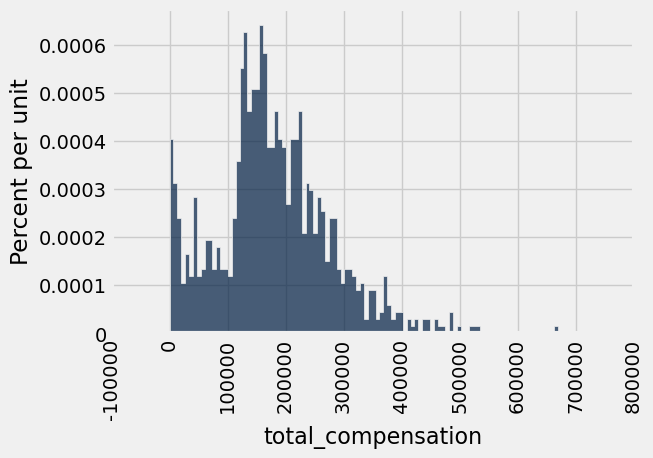

In [ ]:
sf.select('total_compensation').hist(bins=100)

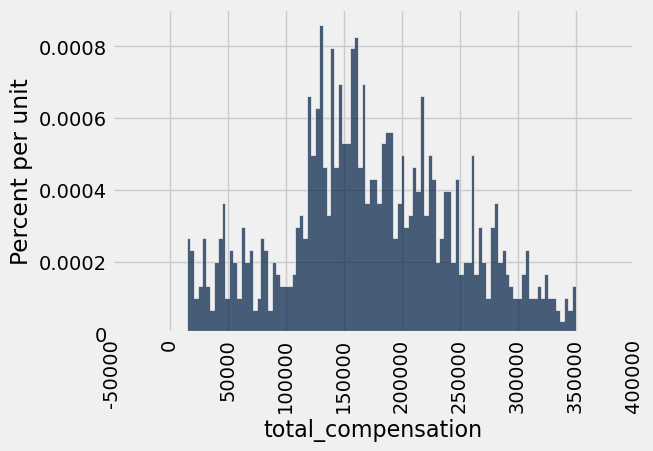

In [ ]:
bottom_5 =percentile(5,sf.column('total_compensation'))
top_5 = percentile(95,sf.column('total_compensation'))
sf = sf.where('total_compensation',are.between_or_equal_to(bottom_5,top_5))
sf.select('total_compensation').hist(bins=100)

In [ ]:
pop_median = np.median(sf.column('total_compensation'))
pop_median

167555.73999999999

In [ ]:
our_sample = sf.sample(400, with_replacement=False)
our_sample.show(5)

job,total_salary,total_compensation
Custodian,74370.4,111383
Sen Hospital Eligibility Wrkr,113328,158443
Custodian,71137.5,107087
Registered Nurse,170585,226807
Attorney (Civil/Criminal),272375,348320


In [ ]:
np.median(our_sample.column('total_compensation'))

162995.78499999997

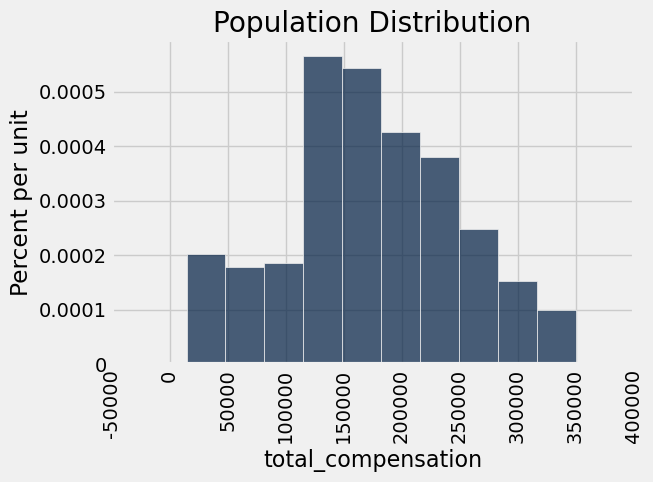

In [ ]:
sf.hist('total_compensation', bins=10)
plt.title('Population Distribution')
plt.show()

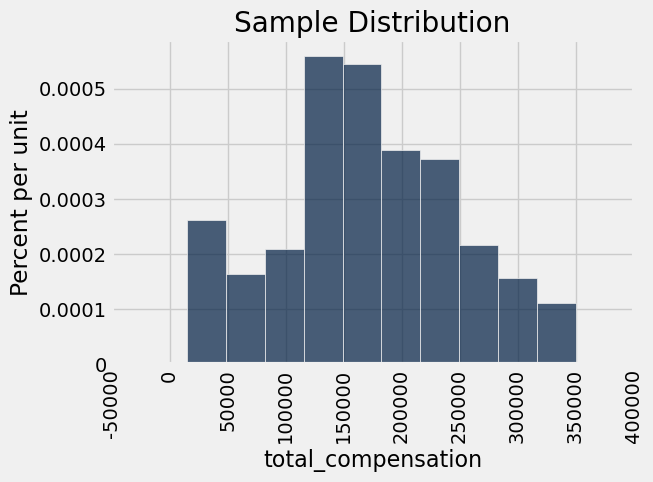

In [ ]:
our_sample.hist('total_compensation', bins=10)
plt.title('Sample Distribution')
plt.show()

---

### Variability of the Estimate

* One sample $\implies$ One estimate
* But the random sample could have come out differently
* And so the estimate could have been different
* **Big question**: How different would it be if we did it again?


---

### Demo: Variability of the Estimate

Create a function that samples randomly from the `sf` table and returns the sample median for `total_compensation`.

In [ ]:
def generate_sample_median(samp_size):
    our_sample =  sf.sample(samp_size, with_replacement=False)
    return np.median(our_sample.column('total_compensation'))

In [ ]:
sample_median = generate_sample_median(400)
sample_median

166846.02499999999

---

### Quantifying Uncertainty

* The estimate is usually not exactly right: `Estimate = Parameter + Error`
* How accurate is the estimate, usually?
* When we have a census, we can do this by simulation


---

### Demo: Quantifying Uncertainty

* Compute the error if the sample median is used to estimate the population median for total compensation. Re-run the above function to see how the error varies.
* Generate 1000 random samples of size 400 and calculate the total compensation median for each sample. Store the median values in an array and visualize the sample distribution along with the population median.
* Visualize the distribution of errors found from using the sample medians to estimate the population median.

In [ ]:
error = sample_median - pop_median
error

-709.71499999999651

In [ ]:
sample_medians = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(400)
    sample_medians = np.append(sample_medians, new_median)

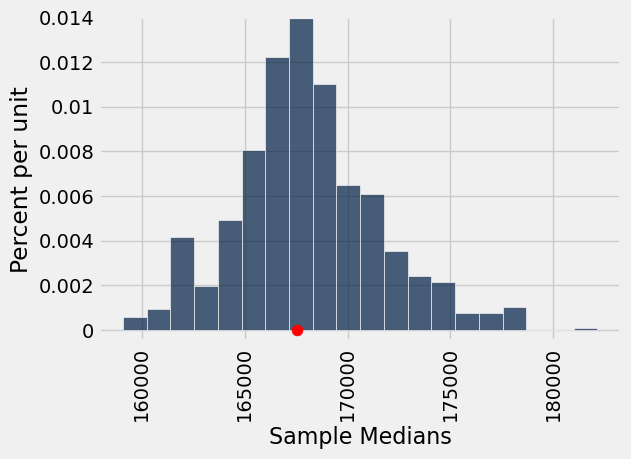

In [ ]:
Table().with_column(
    'Sample Medians', sample_medians
).hist(bins = 20)

plt.ylim(-0.000005, 0.00014)
plt.scatter(pop_median, 0, color="red", s=60)
plt.show()

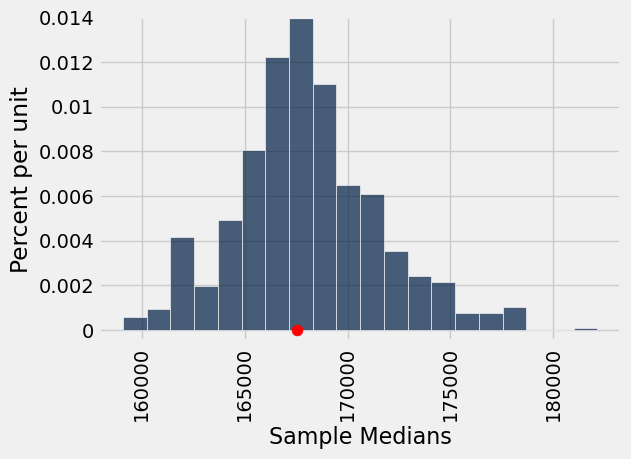

In [ ]:
Table().with_column(
    'Sample Medians', sample_medians
).hist(bins = 20)

plt.ylim(-0.000005, 0.00014)
plt.scatter(pop_median, 0, color="red", s=60)
plt.show()

---

### Where to Get Another Sample?

* We want to understand the variability of our estimate
* Given the population, we could simulate... but we only have the sample!
* To get many values of the estimate, we needed many random samples
* We can't go back and sample again from the population:
    * No time, no money
* Stuck?


---

## The Bootstrap

---

### The Bootstrap

* A technique for simulating repeated random sampling
* All that we have is the original sample... which is large and random
* Therefore, it probably resembles the population
* So we sample at random from the original sample!

---

### The Problem

* All we have is the random sample
* We know it could have come out differently
* We need to know how different, to quantify the variability in estimates based on the sample
* So we need to create another sample ... or two ... or more


<img src="./the_problem.png" width=55%>

---

### Why the Bootstrap Works

All of the resamples look pretty **similar**, most likely.

<img src="./why_the_bootstrap_works.png" width=90%>

---

### Why We Need the Bootstrap

<img src="./why_we_need_the_bootstrap.png" width=90%>

---

### The Bootstrap Principle

Resampling from the original random sample $\approx$ Sampling from the population ... with high probability
* Useful method for estimating many parameters if the original random sample is large enough
* But doesn't work well for estimating some parameters




---

### Key to Resampling

* From the original sample,
    * draw at random
    * with replacement
    * as many values as the original sample contained
* The size of the new sample has to be the same as the original one, so that the two estimates are comparable


---

### The Bootstrap Process

---

#### One Random Sample

True but unknown distribution (population) → Random sample (the original sample)



---

#### Bootstrap

Empirical distribution of original sample (“population”) → Bootstrap sample 1
* → Estimate 1
* → Bootstrap sample 2
* → Estimate 2
* ...
* → Bootstrap sample 1000
* → Estimate 1000

---

### Demo: Bootstrap

* Take a bootstrap (re)sample (**WITH replacement**) of size 400 from the last sf sample.
* Explore the distribution of 1000 bootstrap resamples from the one sample in relation to the sample median and population median.

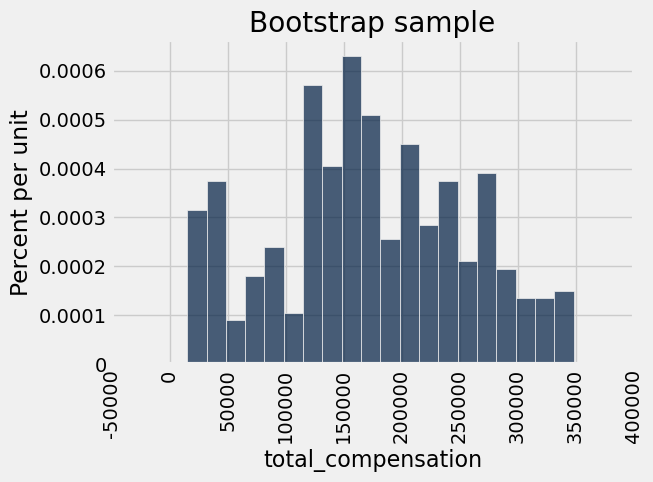

Population Median =        167555.74
Our Sample Median =        166846.025
Bootstrap Sample Median =  166851.375


In [ ]:
boot_sample = our_sample.sample(400, with_replacement=True)
boot_sample.hist('total_compensation', bins=20)
plt.title('Bootstrap sample')
plt.show()

print("Population Median =       ", pop_median)
print("Our Sample Median =       ", sample_median)
print("Bootstrap Sample Median = ",
      np.median(boot_sample.column('total_compensation')))

In [ ]:
def one_bootstrap_median():
    single_sample = our_sample.sample()
    return np.median(single_sample.column('total_compensation'))

In [ ]:
one_bootstrap_median()

160470.26000000001

In [ ]:
bootstrap_medians = make_array()
for i in np.arange(1000):
    new_median = one_bootstrap_median()
    bootstrap_medians = np.append(bootstrap_medians, new_median)

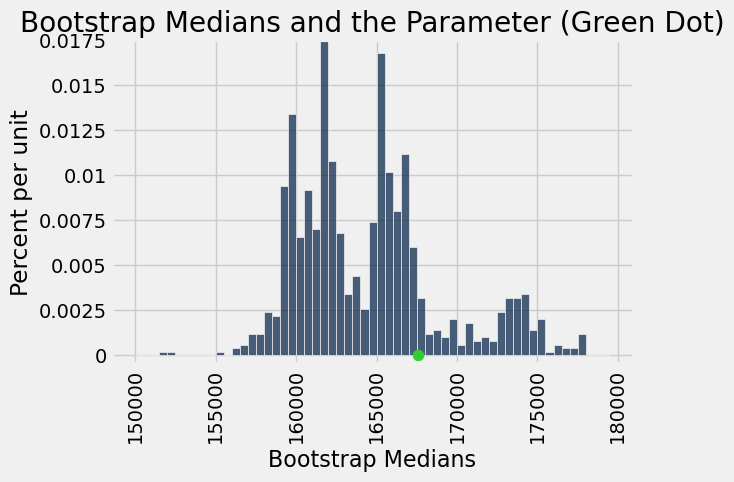

In [ ]:
resampled_medians = Table().with_column(
    'Bootstrap Medians', bootstrap_medians)
median_bins=np.arange(150000, 180000, 500)
resampled_medians.hist('Bootstrap Medians', bins=median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plt.ylim(-0.000005, 0.000175)
plt.scatter(pop_median, 0, color=parameter_green, s=60)
plt.title('Bootstrap Medians and the Parameter (Green Dot)');
plt.show()

In [ ]:
resampled_medians

Bootstrap Medians
168599
162744
167484
169617
163914
162744
161914
160470
167163
159709


---

## Confidence Intervals

---

### 95% Confidence Interval

* Interval of estimates of a parameter
* Based on random sampling
* 95% is called the confidence level
    * Could be any percent between 0 and 100
    * Higher level means wider intervals
* The confidence is in the process that gives the interval: It generates a "good" interval about 95% of the time.

---

### Demo: Confidence Intervals

Make an interval based on the middle 95% of bootstrap samples.

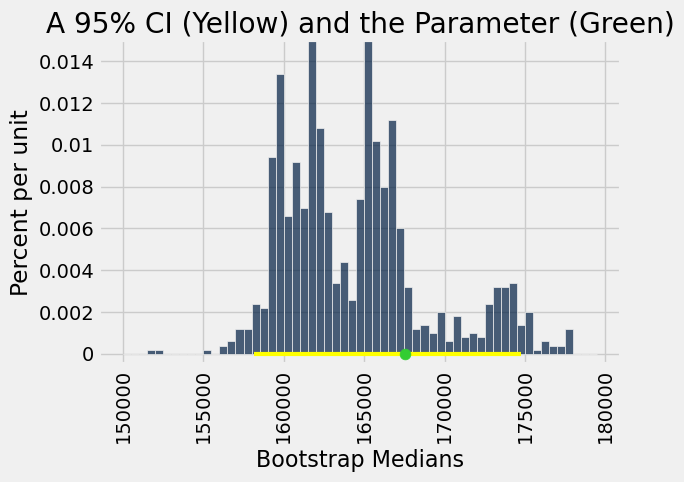

In [ ]:
left = percentile(2.5, bootstrap_medians)
right = percentile(97.5, bootstrap_medians)

resampled_medians.hist('Bootstrap Medians', bins=median_bins)

plt.ylim(-0.000005, 0.00015)
plt.plot([left, right], [0,0], color="yellow",lw=3, zorder=1)
plt.scatter(pop_median, 0, color=parameter_green, s=60, zorder=2)
plt.title('A 95% CI (Yellow) and the Parameter (Green)')
plt.show()

---

## Attribution

This content is licensed under the <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0)</a> and derived from the <a href="https://www.data8.org/">Data 8: The Foundations of Data Science</a> offered by the University of California, Berkeley.

<img src="./by-nc-sa.png" width=100px>